In [1]:
from HestonFFT import Call_Heston
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as k
import pandas as pd
import time
import torch.nn as nn
from Greeks import *
from joblib import load, dump
import scipy
from optim import optim
from ModelDeep import ModelDeep
from ModelLarge import ModelLarge

In [2]:
# load the greeks obtained with Matlab and FFT
greeks = pd.read_csv("greeks.csv", header=None)
greeks.columns = ["theta", "delta", "vega", "vegalt", "rho"]
Quantile = lambda level: greeks.quantile(level)

# load the dataset for the greeks
df = pd.read_csv("HestonGreeks.csv").to_numpy()[:, 1:]
X = df[:, 1:]
y = df[:, 0]
TensorX = torch.from_numpy(X)

# dictionary used for calculations
n = [None, None, None, "vegalt", "rho", "theta", "delta", "vega"]
names = dict(zip(n, [j for j in range(len(n))]))

In [15]:
# load the different models
gprS = load("GPR5000.joblib")
gprM = load("GPR10000.joblib")
gprL = load("GPR20000.joblib")
gpr = [gprS, gprM, gprL]
gpr_names = ["GPR 5000", "GPR10000", "GPR 20000"]
trainsets = ["HestonTrain5000.csv", "HestonTrain10000.csv", "HestonTrain20000.csv"]

NNLarge = torch.load("modelNNLarge.pt")
NNDeep = torch.load("modelNNDeep.pt")
NN = [NNLarge, NNDeep]
NN_names = ["Neural Net Large", "Neural Net Deep"]

In [4]:
GreekNNs = []
for NN_ in NN:
    GreekNN = pd.DataFrame(
        columns=greeks.columns, index=[j for j in range(TensorX.shape[0])]
    )
    for g in greeks.columns:
        GreekNN[g] = (
            derivativeNN(NN_, TensorX, g, names, h=0.01, diff="doublecentral")
            .detach()
            .numpy()
        )
    GreekNNs.append(GreekNN)

In [5]:
GreekGPRs = []
for index, gpr_ in enumerate(gpr):
    trainX = pd.read_csv(trainsets[index]).to_numpy()[:, 2:]
    GreekGPR = pd.DataFrame(
        columns=greeks.columns, index=[j for j in range(X.shape[0])]
    )
    for g in greeks.columns:
        GreekGPR[g] = derivativeGPR(gpr_, X, trainX, g, names)
    GreekGPRs.append(GreekGPR)

In [6]:
# now let's see the performance of Neural Networks
for index, GreekNN in enumerate(GreekNNs):
    if index != 0:
        print("\n")
    print(f"{NN_names[index]} Quantile 5%")
    index = greeks >= Quantile(0.05)
    absNN = np.abs((greeks[index] - GreekNN[index]) / greeks[index]) * 100
    AAE_NN = absNN.mean(axis=0)
    print("Average Absolute Percentage Error")
    print(AAE_NN.apply(lambda x: str(np.round(x, 3)) + "%"))
    MAE_NN = absNN.max(axis=0)
    print("\nMaximum Absolute Percentage Error")
    print(MAE_NN.apply(lambda x: str(np.round(x, 3)) + "%"))

Neural Net Large Quantile 5%
Average Absolute Percentage Error
theta     4.897%
delta     1.352%
vega      5.945%
vegalt    5.447%
rho       2.647%
dtype: object

Maximum Absolute Percentage Error
theta      186.97%
delta        64.6%
vega      160.982%
vegalt    297.002%
rho         34.52%
dtype: object


Neural Net Deep Quantile 5%
Average Absolute Percentage Error
theta     5.655%
delta     1.445%
vega      7.859%
vegalt    7.128%
rho       3.225%
dtype: object

Maximum Absolute Percentage Error
theta     393.191%
delta      71.963%
vega       394.67%
vegalt    481.044%
rho        58.272%
dtype: object


In [7]:
for index, GreekGPR in enumerate(GreekGPRs):

    if index != 0:
        print("\n")
    print(f"{gpr_names[index]} Quantile 5%")
    index = greeks >= Quantile(0.05)

    absGPR = np.absolute((greeks[index] - GreekGPR[index]) / greeks[index]) * 100
    AAE_GPR = absGPR.mean(axis=0)
    print("Average Absolute Percentage Error")
    print(AAE_GPR.apply(lambda x: str(np.round(x, 3)) + "%"))
    MAE_GPR = absGPR.max(axis=0)
    print("\nMaximum Absolute Percentage Error")
    print(MAE_GPR.apply(lambda x: str(np.round(x, 3)) + "%"))

GPR 5000 Quantile 5%
Average Absolute Percentage Error
theta     378.857%
delta       1.352%
vega       25.925%
vegalt     27.973%
rho         5.273%
dtype: object

Maximum Absolute Percentage Error
theta     319539.053%
delta         74.904%
vega        2756.443%
vegalt      6658.632%
rho          338.603%
dtype: object


GPR10000 Quantile 5%
Average Absolute Percentage Error
theta     612.544%
delta       1.185%
vega       12.359%
vegalt     18.818%
rho         4.732%
dtype: object

Maximum Absolute Percentage Error
theta     512521.651%
delta         52.298%
vega        1169.004%
vegalt      3486.175%
rho          569.148%
dtype: object


GPR 20000 Quantile 5%
Average Absolute Percentage Error
theta     665.748%
delta       1.167%
vega       10.362%
vegalt     18.714%
rho         3.195%
dtype: object

Maximum Absolute Percentage Error
theta     542611.794%
delta         49.239%
vega        2016.875%
vegalt      3228.421%
rho          141.033%
dtype: object


In [8]:
# set here how dense the grid
from PlotUtils import plot3d

# define the parameters and create the dataset to use to visualize surfaces
n = 150
rho = -0.65
sigma = 0.05
kappa = 2
nu = 0.05
r = 0.02
T = np.linspace(1 / 12, 1.5, n)
K = np.linspace(0.5, 1.5, n)
V = 0.02

rows, cols = np.indices((T.shape[0], K.shape[0]))
T_ = T[rows.ravel()]
K_ = K[cols.ravel()]
XX = np.ones((n * n, 8))
XX[:, 0] = rho
XX[:, 1] = sigma
XX[:, 2] = kappa
XX[:, 3] = nu
XX[:, 4] = r
XX[:, 5] = T_
XX[:, 6] = K_
XX[:, 7] = V


TensorXX = torch.from_numpy(XX)

In [9]:
# save the dataset
tosave = pd.DataFrame(
    columns=["Price", "rho", "sigma", "kappa", "nu", "r", "T", "K", "V"],
    index=[j for j in range(XX.shape[0])],
)
tosave.iloc[:, 1:] = XX
tosave.iloc[:, 0] = np.nan
tosave.to_csv("ToGreek.csv")

In [16]:
# load the dataset with the values of the True greeks obtained with Matlab
n = 150
greeked = pd.read_csv("Greeked.csv", header=None)
greeked.columns = ["theta", "delta", "vega", "vegalt", "rho"]

delta = greeked["delta"].to_numpy().reshape(n, n)
theta = greeked["theta"].to_numpy().reshape(n, n)
vega = greeked["vega"].to_numpy().reshape(n, n)
rho_ = greeked["rho"].to_numpy().reshape(n, n)

(10000, 8)


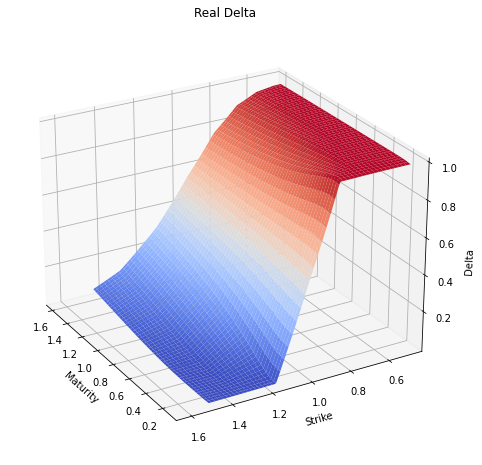

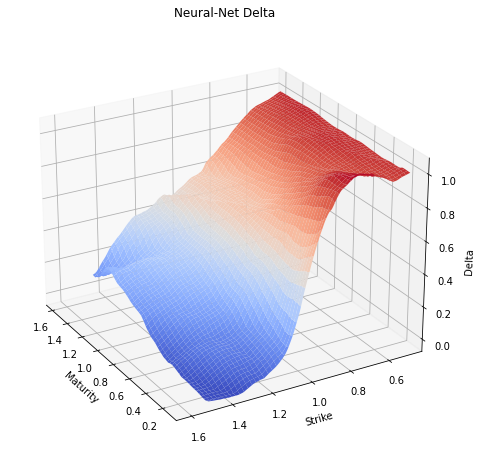

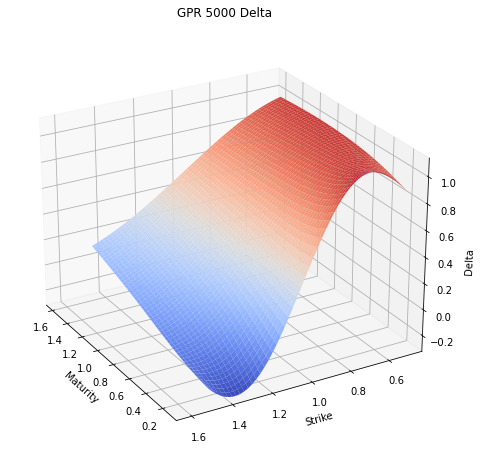

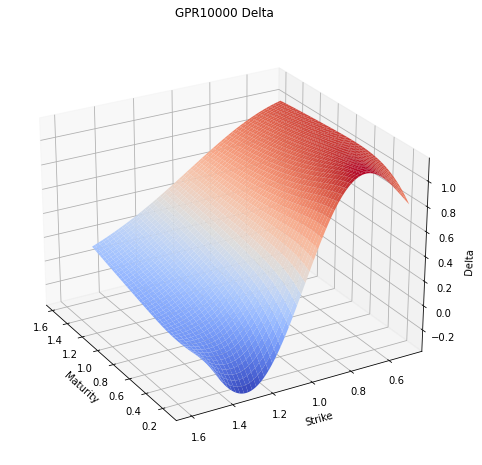

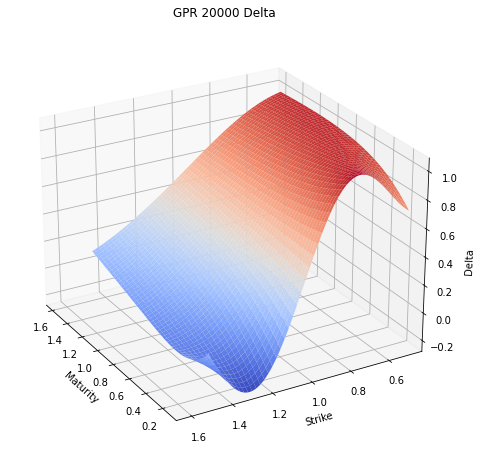

In [20]:
n = 150

deltaNN = (
    derivativeNN(NNLarge, TensorXX, "delta", names, h=0.1, diff="doublecentral")
    .detach()
    .numpy()
)

# real one
x, y = np.meshgrid(T, K, indexing="ij")
z = delta
plot3d(x, y, z, "Maturity", "Strike", "Delta", "Real Delta", view=(25, -30))

# Neural Network
x, y = np.meshgrid(T, K, indexing="ij")
z = deltaNN.reshape((n, n))
plot3d(x, y, z, "Maturity", "Strike", "Delta", "Neural-Net Delta", view=(25, -30))

for index, gpr_ in enumerate(gpr):
    trainX = pd.read_csv(trainsets[index]).to_numpy()[:, 2:]
    deltaGPR = derivativeGPR(gpr_, XX, trainX, "delta", names)
    x, y = np.meshgrid(T, K, indexing="ij")
    z = deltaGPR.reshape((n, n))
    plot3d(
        x,
        y,
        z,
        "Maturity",
        "Strike",
        "Delta",
        f"{gpr_names[index]} Delta",
        view=(25, -30),
    )

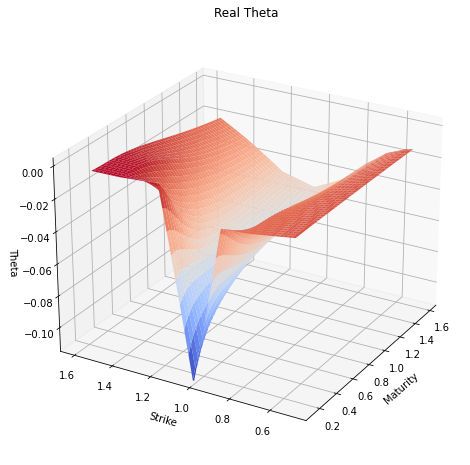

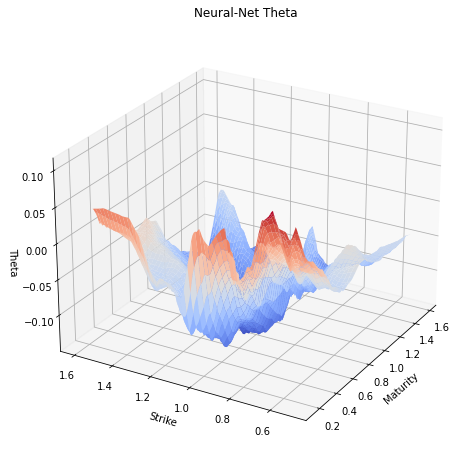

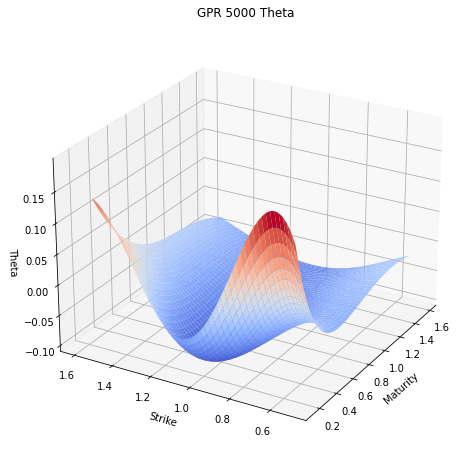

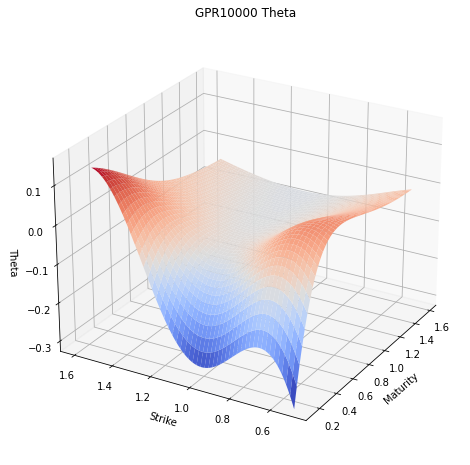

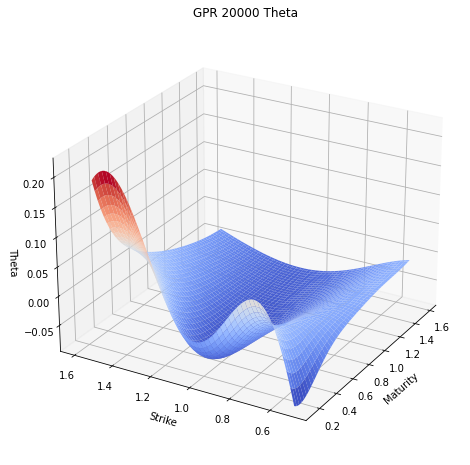

In [23]:
n = 150

thetaNN = (
    derivativeNN(NNLarge, TensorXX, "theta", names, h=0.1, diff="doublecentral")
    .detach()
    .numpy()
)

# real one
x, y = np.meshgrid(T, K, indexing="ij")
z = theta
plot3d(x, y, z, "Maturity", "Strike", "Theta", "Real Theta")

# Neural Network
x, y = np.meshgrid(T, K, indexing="ij")
z = thetaNN.reshape((n, n))
plot3d(x, y, z, "Maturity", "Strike", "Theta", "Neural-Net Theta")

for index, gpr_ in enumerate(gpr):
    trainX = pd.read_csv(trainsets[index]).to_numpy()[:, 2:]
    thetaGPR = derivativeGPR(gpr_, XX, trainX, "theta", names)
    x, y = np.meshgrid(T, K, indexing="ij")
    z = thetaGPR.reshape((n, n))
    plot3d(x, y, z, "Maturity", "Strike", "Theta", f"{gpr_names[index]} Theta")

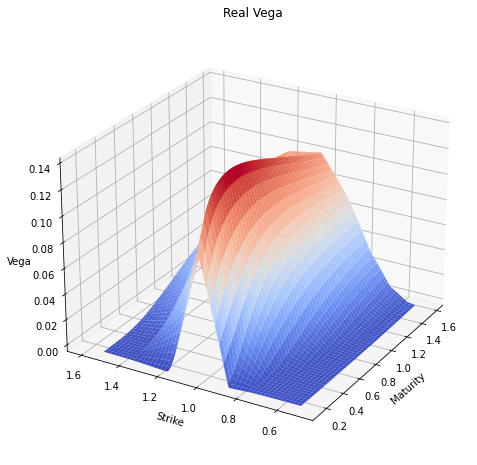

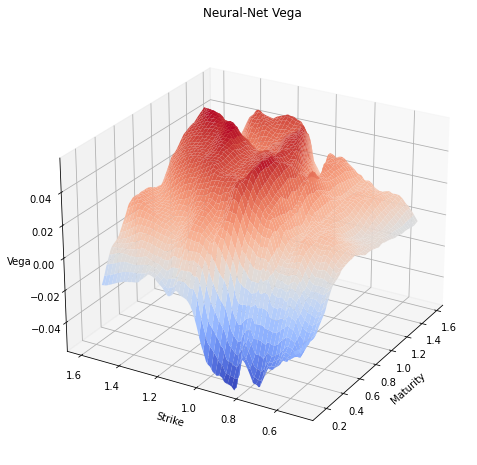

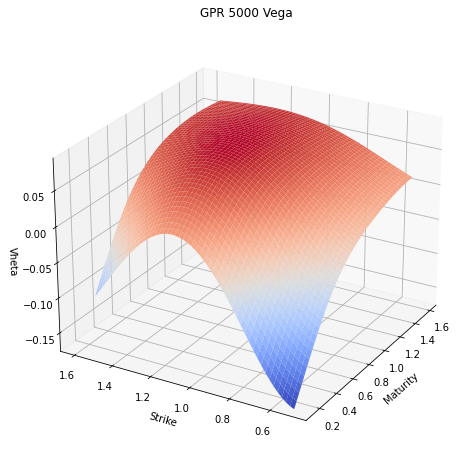

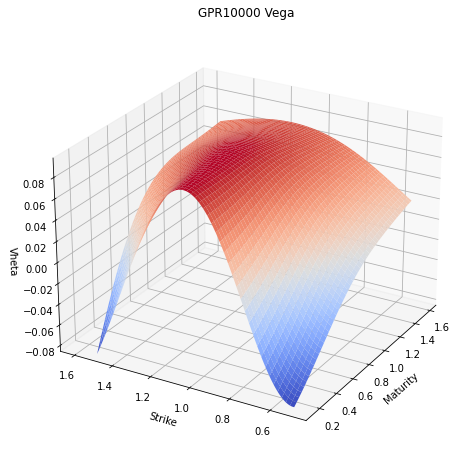

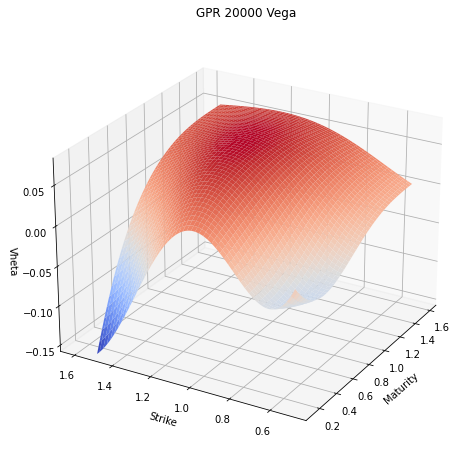

In [24]:
n = 150

vegaNN = (
    derivativeNN(NNLarge, TensorXX, "vega", names, h=0.1, diff="doublecentral")
    .detach()
    .numpy()
)

# real one
x, y = np.meshgrid(T, K, indexing="ij")
z = vega
plot3d(x, y, z, "Maturity", "Strike", "Vega", "Real Vega")

# Neural Network
x, y = np.meshgrid(T, K, indexing="ij")
z = vegaNN.reshape((n, n))
plot3d(x, y, z, "Maturity", "Strike", "Vega", "Neural-Net Vega")

for index, gpr_ in enumerate(gpr):
    trainX = pd.read_csv(trainsets[index]).to_numpy()[:, 2:]
    vegaGPR = derivativeGPR(gpr_, XX, trainX, "vega", names)
    x, y = np.meshgrid(T, K, indexing="ij")
    z = vegaGPR.reshape((n, n))
    plot3d(x, y, z, "Maturity", "Strike", "Vheta", f"{gpr_names[index]} Vega")

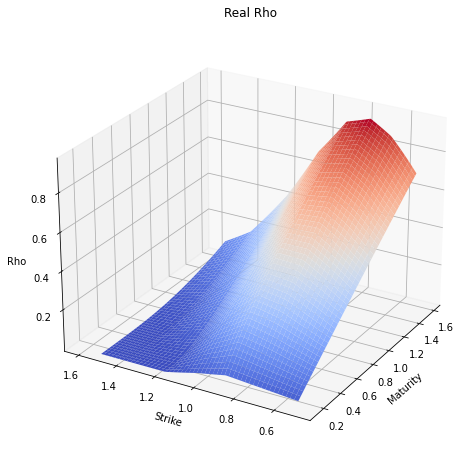

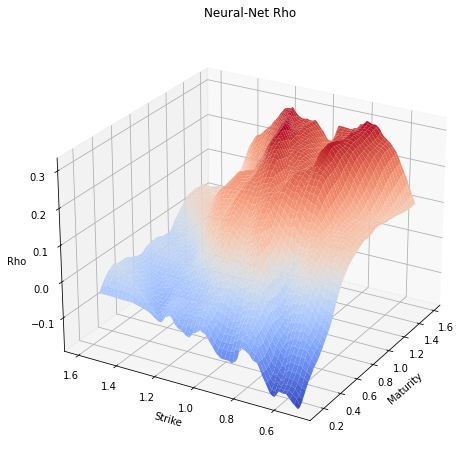

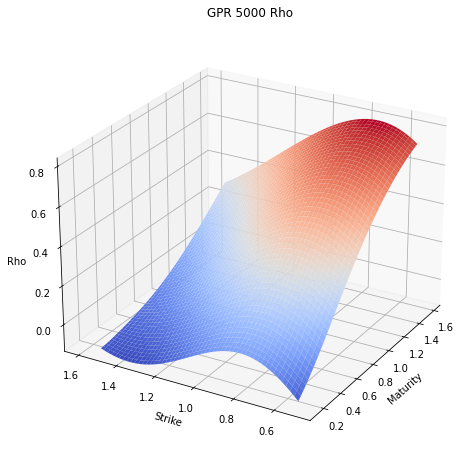

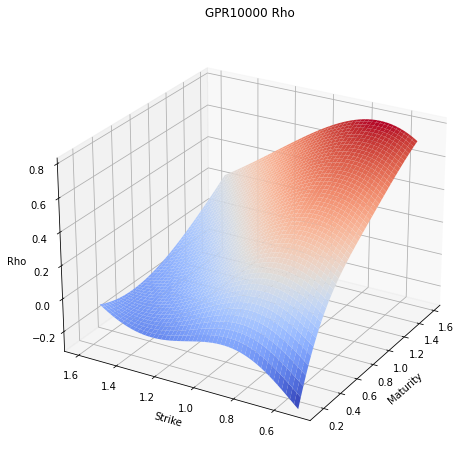

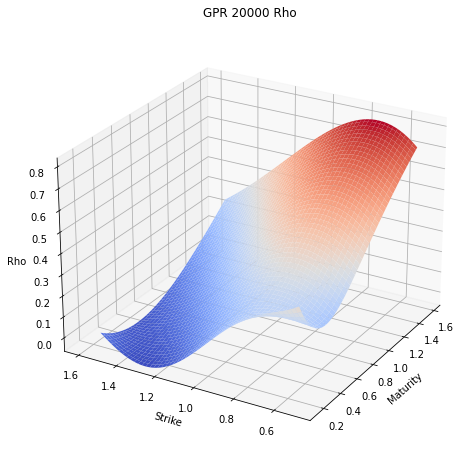

In [27]:
n = 150

rhoNN = (
    derivativeNN(NNLarge, TensorXX, "rho", names, h=0.1, diff="doublecentral")
    .detach()
    .numpy()
)

# real one
x, y = np.meshgrid(T, K, indexing="ij")
z = rho_
plot3d(x, y, z, "Maturity", "Strike", "Rho", "Real Rho")

# Neural Network
x, y = np.meshgrid(T, K, indexing="ij")
z = rhoNN.reshape((n, n))
plot3d(x, y, z, "Maturity", "Strike", "Rho", "Neural-Net Rho")

for index, gpr_ in enumerate(gpr):
    trainX = pd.read_csv(trainsets[index]).to_numpy()[:, 2:]
    rhoGPR = derivativeGPR(gpr_, XX, trainX, "rho", names)
    x, y = np.meshgrid(T, K, indexing="ij")
    z = rhoGPR.reshape((n, n))
    plot3d(x, y, z, "Maturity", "Strike", "Rho", f"{gpr_names[index]} Rho")